In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [22]:
import deepxde as dde

Using backend: paddle
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, jax.
paddle supports more examples now and is recommended.


$\frac{d^2u}{dx^2} = q(x), \quad x \in [-1, 1]$ avec $u(-1) = 0, \quad u(1) = 0$
Here, both u(x) and q(x) are unknown. Furthermore, we have the measurement of u(x) at 100 points.

The reference solution is u(x) = $\sin(\pi x), \quad q(x) = -\pi^2 \sin(\pi x).$

In [23]:
def gen_traindata(num):
    xvals = np.linspace(-1, 1, num).reshape(num, 1)
    uvals = np.sin(np.pi * xvals)
    return xvals, uvals

In [24]:
geom = dde.geometry.Interval(-1, 1)

In [25]:
def pde(x, y):
    u, q = y[:, 0:1], y[:, 1:2]
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return -du_xx + q

In [26]:
def sol(x):
    return np.sin(np.pi * x)

In [27]:
bc = dde.icbc.DirichletBC(geom, sol, lambda _, on_boundary: on_boundary, component=0)

In [28]:
ob_x, ob_u = gen_traindata(100)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

In [29]:
data = dde.data.PDE(
    geom,
    pde,
    [bc, observe_u],
    num_domain=200,
    num_boundary=2,
    anchors=ob_x,
    num_test=1000,
)

In [30]:
net = dde.nn.PFNN([1, [20, 20], [20, 20], [20, 20], 2], "tanh", "Glorot uniform")

In [31]:
model = dde.Model(data, net)
model.compile("adam", lr=0.0001, loss_weights=[1, 100, 1000])

Compiling model...
'compile' took 0.000712 s



In [32]:
losshistory, train_state = model.train(iterations=20000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.01e-03, 7.31e+00, 6.98e+02]    [7.86e-03, 7.31e+00, 6.98e+02]    []  
1000      [5.25e-03, 4.85e+01, 1.79e+02]    [5.16e-03, 4.85e+01, 1.79e+02]    []  
2000      [8.45e-01, 1.73e+01, 4.16e+01]    [8.48e-01, 1.73e+01, 4.16e+01]    []  
3000      [1.56e-01, 9.55e-01, 2.41e+00]    [1.57e-01, 9.55e-01, 2.41e+00]    []  
4000      [2.07e-02, 4.66e-02, 1.16e-01]    [1.92e-02, 4.66e-02, 1.16e-01]    []  
5000      [5.16e-03, 2.08e-03, 4.60e-03]    [4.53e-03, 2.08e-03, 4.60e-03]    []  
6000      [1.13e-03, 1.40e-04, 5.71e-04]    [8.97e-04, 1.40e-04, 5.71e-04]    []  
7000      [5.40e-04, 3.37e-05, 5.14e-04]    [4.39e-04, 3.37e-05, 5.14e-04]    []  
8000      [3.64e-04, 2.93e-05, 4.65e-04]    [3.08e-04, 2.93e-05, 4.65e-04]    []  
9000      [2.51e-04, 2.81e-05, 3.96e-04]    [2.16e-04, 2.81e-05, 3.96e-04]    []  
10000     [1.60e-04, 2.57e-05, 3.26e-04]    [1.39e-04, 2.57e-

Saving loss history to /Users/Louis/GitHub/inverse_problem/loss.dat ...
Saving training data to /Users/Louis/GitHub/inverse_problem/train.dat ...
Saving test data to /Users/Louis/GitHub/inverse_problem/test.dat ...


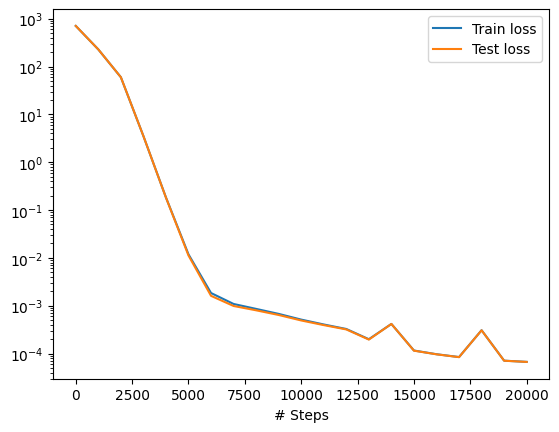

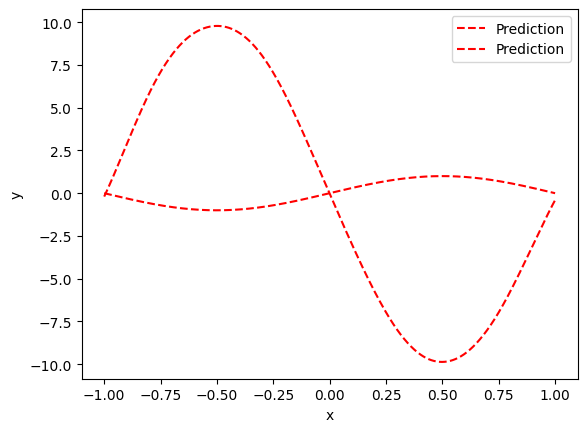

In [33]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [34]:
# view results
x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, qhat = yhat[:, 0:1], yhat[:, 1:2]


l2 relative error for u: 0.0003442113


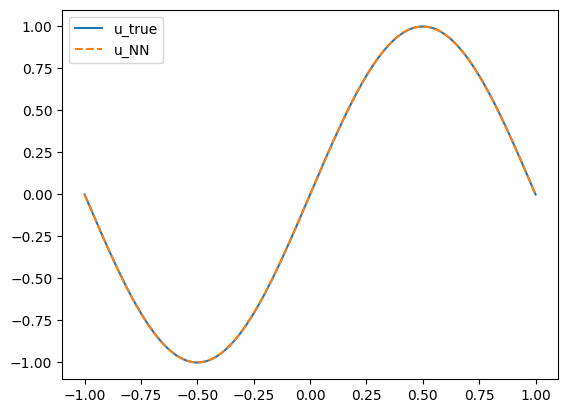

In [35]:
utrue = np.sin(np.pi * x)
print("l2 relative error for u: " + str(dde.metrics.l2_relative_error(utrue, uhat)))
plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()

l2 relative error for q: 0.0121696945


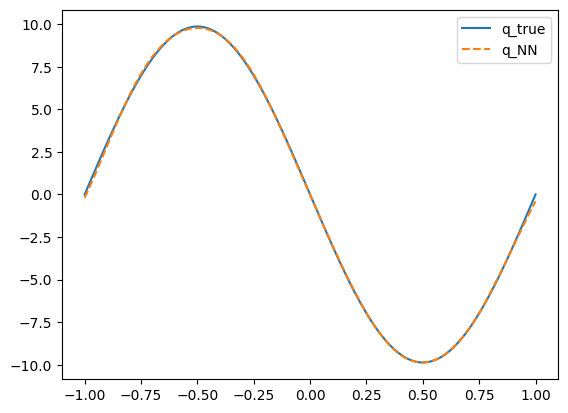

In [36]:
qtrue = -np.pi ** 2 * np.sin(np.pi * x)
print("l2 relative error for q: " + str(dde.metrics.l2_relative_error(qtrue, qhat)))
plt.figure()
plt.plot(x, qtrue, "-", label="q_true")
plt.plot(x, qhat, "--", label="q_NN")
plt.legend()